In [2]:
import numpy  as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
RAND_SEED=1

      phase speed     phase
Mean    -0.000002 -6.359112
Std      0.008713  2.486367
Var      0.000076  6.182020


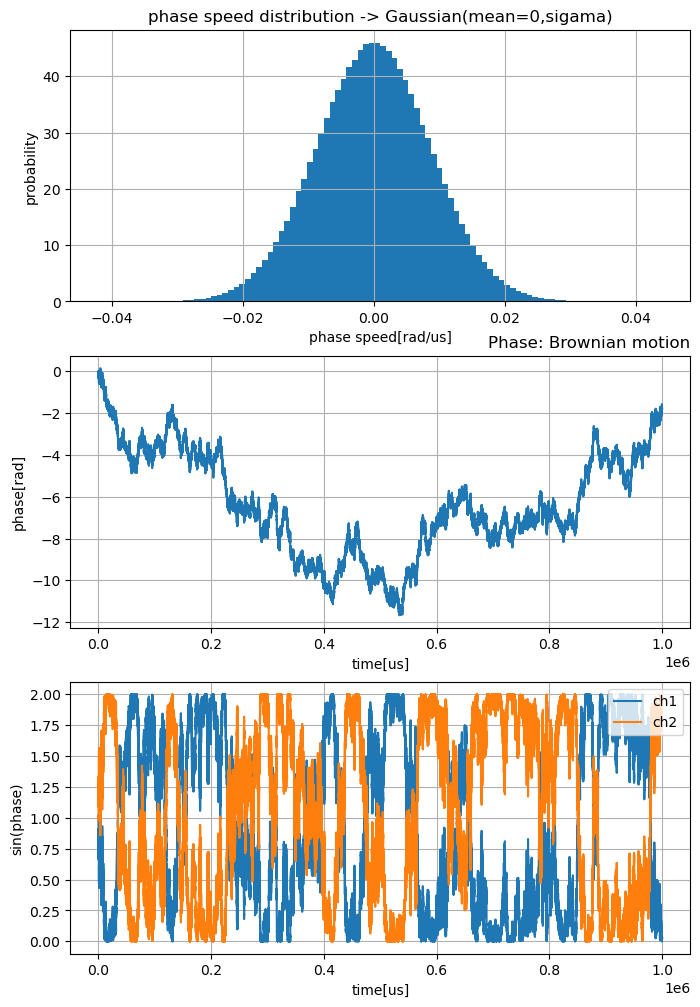

In [3]:
GAMMY=1.0

def get_sig_from_speed(phase_speed,channel):
    phase=np.cumsum(phase_speed)
    #phase*=np.pi/180
    if channel==1:
        return SIG_AMP*(GAMMY+np.sin(phase))
    elif channel==2:
        return SIG_AMP*(GAMMY-np.sin(phase))
def get_sig_from_phase(phase,channel):
    #phase*=np.pi/180
    if channel==1:
        return SIG_AMP*(GAMMY+np.sin(phase))
    elif channel==2:
        return SIG_AMP*(GAMMY-np.sin(phase))

PHASE_SEEPD=0.5/180*np.pi # deg/us -> rad/us
SIG_AMP=1 # 10sample/us  cps=10M
time_axis=np.arange(0,1e6,1) #1us分辨率，len=1s  SR=1M
rng=np.random.default_rng(RAND_SEED)
phase_speed=rng.normal(0,PHASE_SEEPD,time_axis.shape)
phase_speed[0]=0
phase=np.cumsum(phase_speed)
sig_ch1=get_sig_from_speed(phase_speed,1)
sig_ch2=get_sig_from_speed(phase_speed,2)
plt.figure(figsize=(8,12))
plt.subplot(3,1,1)
plt.hist(phase_speed,bins=100,density=True)
plt.ylabel('probability')
plt.xlabel('phase speed[rad/us]')
plt.title('phase speed distribution -> Gaussian(mean=0,sigama)')
plt.grid()
plt.subplot(3,1,2)
plt.plot(time_axis,phase)
plt.xlabel('time[us]')
plt.ylabel('phase[rad]')
plt.title('Phase: Brownian motion',loc='right')
plt.grid()
plt.subplot(3,1,3)
plt.plot(time_axis,sig_ch1,label='ch1')
plt.plot(time_axis,sig_ch2,label='ch2')
plt.xlabel('time[us]')
plt.ylabel('sin(phase)')
plt.grid()
plt.legend(loc=1)
#plt.xlim(0,100000)

df=pd.DataFrame({'Mean':phase_speed.mean(),'Std':phase_speed.std(),'Var':phase_speed.var()},index=['phase speed']).T
def push_data(data,name):
    df[name]=[data.mean(),data.std(),data.var()]
    print(df)
push_data(phase,'phase')

In [4]:
def get_phase_from_count(ch1,ch2):
    if ch1+ch2==0:
        return 0
    else:
        return np.arcsin((ch1-ch2)/(ch1+ch2))

def measure_count(sig,method):
    """method=0:测量返回测量时间内最后一个时刻的phase;  
    method=1:测量时间内的phase的积分;  
    method=2:测量时间内的phase的积分，并引入shot noise;"""
    if method==0:
        return sig[-1]
    elif method==1:
        return sig.sum()
    elif method==2:
        return rng.poisson(sig.sum())

def fb_weight(measure, time_exposure, sigma=3):
    phase_speed_in_measure=np.sqrt(time_exposure)*PHASE_SEEPD #sigma
    threshold=sigma*phase_speed_in_measure #3 sigma
    weight=lambda x: np.sign(x) *(threshold + (np.abs(x) - threshold)*np.exp(- (np.abs(x) - threshold)/phase_speed_in_measure))
    mask = np.abs(measure) > threshold
    measure_filtered = np.where(mask, weight(measure),measure)
    return measure_filtered

    
def simu_phase(phase_speed,time_exposure,method):
    """
    method 1: instant feedback  
    method 2: average feedback  
    method 3: average feedback with iteration  
    method 4: weighted feedback  
    """
    
    time_iter1=2 # method 3 迭代参数，每隔time_iter1个exposure再进行一次测量
    
    sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
    sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
    phase_speed_M=np.copy(phase_speed.reshape((-1,time_exposure)))
    phase_M=np.zeros_like(phase_speed_M)
    phase_measure_M=np.zeros(phase_speed_M.shape[0]) # 测量出的反馈量
    phase_measure_it1_M5=np.zeros(phase_speed_M.shape[0])
    rng=np.random.default_rng(RAND_SEED)
    phase_offest=0
    
    for i in tqdm(range(sig_ch1_exposure.shape[0])):
        phase_M[i]=np.cumsum(phase_speed_M[i])+phase_offest
        sig_ch1_exposure[i]=get_sig_from_phase(phase_M[i],1)
        sig_ch2_exposure[i]=get_sig_from_phase(phase_M[i],2)
        ###引入shot noise
        ch1_measure=rng.poisson(sig_ch1_exposure[i].sum())#+rng.poisson(1)-1  # shot noise 应该于计数有关
        ch2_measure=rng.poisson(sig_ch2_exposure[i].sum())#+rng.poisson(1)-1
        phase_measure_M[i]=get_phase_from_count(ch1_measure,ch2_measure)
        
        
        if i<(sig_ch1_exposure.shape[0]-1):
            if method==1:
                phase_speed_M[i+1,0]-=phase_measure_M[i] # 反馈到下一个exposure的起始点
            if method==2 or method==3:
                c0=phase_measure_M[i]
                phase_fb_M=np.sign(phase_measure_M[i])*np.abs(c0)
                phase_speed_M[i+1]-=phase_fb_M/time_exposure # 均匀反馈到下一个exposure时间
            if method==4:
                c0=fb_weight(phase_measure_M[i],time_exposure*(1.2/3)*(1.2/3))
                phase_fb_M=np.sign(phase_measure_M[i])*np.abs(c0)
                phase_speed_M[i+1,0]-=phase_fb_M # 均匀反馈到下一个exposure时间

        if method==3:
            if i%time_iter1==0 and i!=0:
                ch1_measure=rng.poisson(sig_ch1_exposure[i-time_iter1:i].sum())
                ch2_measure=rng.poisson(sig_ch2_exposure[i-time_iter1:i].sum())
                phase_measure_M_it1=get_phase_from_count(ch1_measure,ch2_measure)
                c0=get_phase_from_count(ch1_measure,ch2_measure)#/100
                phase_fb_M=np.sign(phase_measure_M_it1)*np.abs(c0)
                phase_speed_M[i:i+time_iter1]-=phase_fb_M/time_exposure/time_iter1
        
        if method==5:
                ##-- 反馈
            if i<(sig_ch1_exposure.shape[0]-1):
                c0=fb_weight(phase_measure_M[i],time_exposure=time_exposure,sigma=1.2)
                phase_speed_M[i+1,0]-=c0#/time_exposure # 反馈到下一个exposure
            
                ##-- 迭代反馈 one 10*time_exposure
                if i%time_iter1==0 and i!=0:
                    phaseit1=phase_M[i,-1]+phase_speed_M[i+1,0]
                    suffix1=get_sig_from_phase(phaseit1,1)
                    suffix2=get_sig_from_phase(phaseit1,2)
                    ch1_measure=rng.poisson(sig_ch1_exposure[i-time_iter1:i+1].sum()+suffix1)
                    ch2_measure=rng.poisson(sig_ch2_exposure[i-time_iter1:i+1].sum()+suffix2)
                    phase_measure_M5_it1=get_phase_from_count(ch1_measure,ch2_measure)
                    phase_measure_it1_M5[i]=phase_measure_M5_it1
                    c0=fb_weight(phase_measure_M5_it1,time_exposure=time_exposure,sigma=1.2)
                    phase_speed_M[i+1,1]-=c0

        phase_offest=phase_M[i,-1]
    phase_out_M=np.cumsum(phase_speed_M.reshape(-1))
    return phase_out_M


In [1]:
def simu_phase_M5_iter2(phase_speed,sigma0=1.2,sigma1=1.2,sigma2=1.2,RAND_SEED=RAND_SEED):
    time_exposure=2 #us
    time_iter1=2 # iter*time_exposure 
    time_iter2=50 # iter*time_exposure
    #print('time exposure:',time_exposure,'iter:',time_iter1*time_exposure,time_iter2*time_exposure,time_iter3*time_exposure,time_iter4*time_exposure,'us')
    sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
    sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
    phase_speed_M5=np.copy(phase_speed.reshape((-1,time_exposure)))
    phase_M5=np.zeros_like(phase_speed_M5)
    phase_measure_M5=np.zeros(phase_speed_M5.shape[0]) # 测量出的反馈量
    phase_measure_it1_M5=np.zeros(phase_speed_M5.shape[0])
    phase_measure_it2_M5=np.zeros(phase_speed_M5.shape[0])
    rng=np.random.default_rng(RAND_SEED)
    phase_offest=0
    for i in tqdm(range(sig_ch1_exposure.shape[0])):
        phase_M5[i]=np.cumsum(phase_speed_M5[i])+phase_offest
        sig_ch1_exposure[i]=get_sig_from_phase(phase_M5[i],1)
        sig_ch2_exposure[i]=get_sig_from_phase(phase_M5[i],2)
        ch1_measure=rng.poisson(sig_ch1_exposure[i].sum())
        ch2_measure=rng.poisson(sig_ch2_exposure[i].sum())
        phase_measure_M5[i]=get_phase_from_count(ch1_measure,ch2_measure) 
        c0=fb_weight(phase_measure_M5[i],time_exposure=time_exposure,sigma=sigma0)
        phase_fb_M5=c0
        
        ##-- 反馈
        if i<(sig_ch1_exposure.shape[0]-1):
            phase_speed_M5[i+1,0]-=phase_fb_M5#/time_exposure # 反馈到下一个exposure
        
        ##-- 迭代反馈 one 10*time_exposure
        
        if i%time_iter1==0 and i!=0 and i<(sig_ch1_exposure.shape[0]-1):
            phaseit1=phase_M5[i,-1]+phase_speed_M5[i+1,0]
            suffix1=get_sig_from_phase(phaseit1,1)
            suffix2=get_sig_from_phase(phaseit1,2)
            ch1_measure=rng.poisson(sig_ch1_exposure[i-time_iter1:i+1].sum()+suffix1)
            ch2_measure=rng.poisson(sig_ch2_exposure[i-time_iter1:i+1].sum()+suffix2)
            phase_measure_M5_it1=get_phase_from_count(ch1_measure,ch2_measure)
            phase_measure_it1_M5[i]=phase_measure_M5_it1
            c0=fb_weight(phase_measure_M5_it1,time_exposure=time_exposure*time_iter1,sigma=sigma1)
            phase_speed_M5[i+1,1]-=c0
        
        if i%time_iter2==0 and i!=0 and i<(sig_ch1_exposure.shape[0]-2) and i%time_iter1!=0:
            phaseit2=phase_M5[i,-1]+phase_speed_M5[i+1,:2].sum()
            suffix1=get_sig_from_phase(phaseit2,1)
            suffix2=get_sig_from_phase(phaseit2,2)
            ch1_measure=rng.poisson(sig_ch1_exposure[i-time_iter2:i+1].sum()+suffix1)
            ch2_measure=rng.poisson(sig_ch2_exposure[i-time_iter2:i+1].sum()+suffix2)
            phase_measure_M5_it2=get_phase_from_count(ch1_measure,ch2_measure)
            phase_measure_it2_M5[i]=phase_measure_M5_it2
            c0=fb_weight(phase_measure_M5_it2,time_exposure=time_exposure*time_iter2,sigma=sigma2)
            c0=phase_measure_M5_it2
            phase_speed_M5[i+1,1]-=c0
        
        phase_offest=phase_M5[i,-1]
    phase_out_M5=np.cumsum(phase_speed_M5.reshape(-1))
    return phase_out_M5

def simu_phase_M5_iter1(phase_speed,sigma0=1.2,sigma1=1.2,RAND_SEED=RAND_SEED):
    time_exposure=2 #us
    time_iter1=2 # iter*time_exposure 
    #print('time exposure:',time_exposure,'iter:',time_iter1*time_exposure,time_iter2*time_exposure,time_iter3*time_exposure,time_iter4*time_exposure,'us')
    sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
    sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
    phase_speed_M5=np.copy(phase_speed.reshape((-1,time_exposure)))
    phase_M5=np.zeros_like(phase_speed_M5)
    phase_measure_M5=np.zeros(phase_speed_M5.shape[0]) # 测量出的反馈量
    phase_measure_it1_M5=np.zeros(phase_speed_M5.shape[0])
    rng=np.random.default_rng(RAND_SEED)
    phase_offest=0
    for i in tqdm(range(sig_ch1_exposure.shape[0])):
        phase_M5[i]=np.cumsum(phase_speed_M5[i])+phase_offest
        sig_ch1_exposure[i]=get_sig_from_phase(phase_M5[i],1)
        sig_ch2_exposure[i]=get_sig_from_phase(phase_M5[i],2)
        ch1_measure=rng.poisson(sig_ch1_exposure[i].sum())
        ch2_measure=rng.poisson(sig_ch2_exposure[i].sum())
        phase_measure_M5[i]=get_phase_from_count(ch1_measure,ch2_measure) 
        c0=fb_weight(phase_measure_M5[i],time_exposure=time_exposure,sigma=sigma0)
        phase_fb_M5=c0
        
        ##-- 反馈
        if i<(sig_ch1_exposure.shape[0]-1):
            phase_speed_M5[i+1,0]-=phase_fb_M5#/time_exposure # 反馈到下一个exposure
        
        ##-- 迭代反馈 one 10*time_exposure
        
        if i%time_iter1==0 and i!=0 and i<(sig_ch1_exposure.shape[0]-1):
            phaseit1=phase_M5[i,-1]+phase_speed_M5[i+1,0]
            suffix1=get_sig_from_phase(phaseit1,1)
            suffix2=get_sig_from_phase(phaseit1,2)
            ch1_measure=rng.poisson(sig_ch1_exposure[i-time_iter1:i+1].sum()+suffix1)
            ch2_measure=rng.poisson(sig_ch2_exposure[i-time_iter1:i+1].sum()+suffix2)
            phase_measure_M5_it1=get_phase_from_count(ch1_measure,ch2_measure)
            phase_measure_it1_M5[i]=phase_measure_M5_it1
            c0=fb_weight(phase_measure_M5_it1,time_exposure=time_exposure*time_iter1,sigma=sigma1)
            phase_speed_M5[i+1,1]-=c0
        
        phase_offest=phase_M5[i,-1]
    phase_out_M5=np.cumsum(phase_speed_M5.reshape(-1))
    return phase_out_M5


NameError: name 'RAND_SEED' is not defined

In [68]:
phase_out=simu_phase_M5_iter2(phase_speed,sigma0=0.7,sigma1=0.7,sigma2=0.5)
import allantools

  0%|          | 0/500000 [00:00<?, ?it/s]

100%|██████████| 500000/500000 [00:41<00:00, 11956.60it/s]


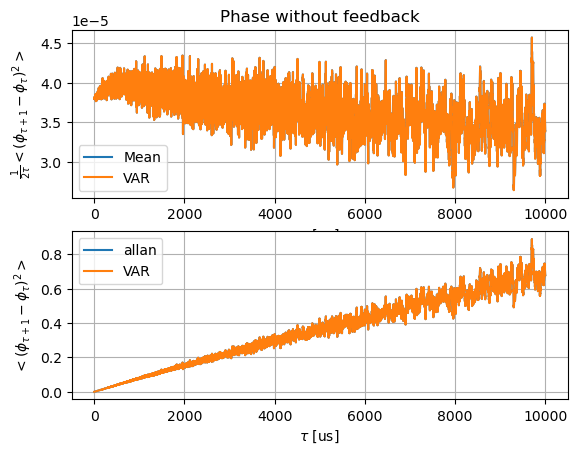

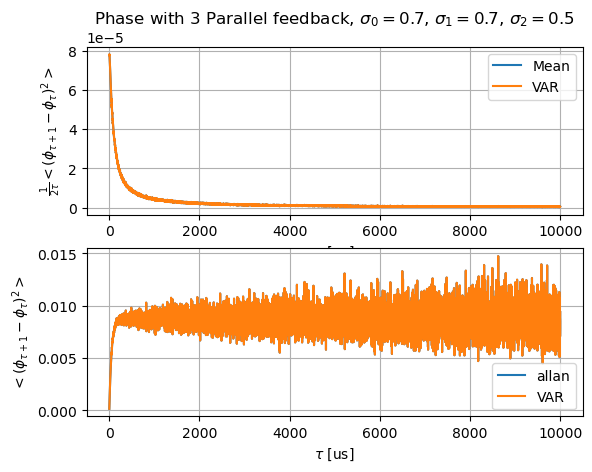

In [71]:
import allantools # https://github.com/aewallin/allantools/
import numpy as np

plt.subplot(211)
plt.title('Phase without feedback')
n=10000
allan_data=np.zeros(n)
var_data=np.zeros(n)
for i in range(n):
    allan_data[i]=np.mean(np.diff(phase[::i+1])**2)/(2*(i+1))
    var_data[i]=np.var(np.diff(phase[::i+1]))/(2*(i+1))

plt.plot(np.arange(n)+1,allan_data,label='Mean')
plt.plot(np.arange(n)+1,var_data,label='VAR')
plt.ylabel(r'$\frac{1}{2\tau}<(\phi_{\tau+1}-\phi_\tau)^2>$')
plt.xlabel('$\\tau$ [us]')
plt.legend()
plt.grid()

plt.subplot(212)
for i in range(n):
    allan_data[i]=np.mean(np.diff(phase[::i+1])**2)
    var_data[i]=np.var(np.diff(phase[::i+1]))

plt.plot(np.arange(n)+1,allan_data,label='allan')
plt.plot(np.arange(n)+1,var_data,label='VAR')
plt.ylabel(r'$<(\phi_{\tau+1}-\phi_\tau)^2>$')
plt.xlabel('$\\tau$ [us]')
plt.legend()
plt.grid()
plt.show()
#-------------------------

plt.subplot(211)
plt.title('Phase with 3 Parallel feedback, $\sigma_0=0.7$, $\sigma_1=0.7$, $\sigma_2=0.5$')
for i in range(n):
    allan_data[i]=np.mean(np.diff(phase_out[::i+1])**2)/(2*(i+1))
    var_data[i]=np.var(np.diff(phase_out[::i+1]))/(2*(i+1))

plt.plot(np.arange(n)+1,allan_data,label='Mean')
plt.plot(np.arange(n)+1,var_data,label='VAR')
plt.ylabel(r'$\frac{1}{2\tau}<(\phi_{\tau+1}-\phi_\tau)^2>$')
plt.xlabel('$\\tau$ [us]')
plt.legend()
plt.grid()

plt.subplot(212)
for i in range(n):
    allan_data[i]=np.mean(np.diff(phase_out[::i+1])**2)
    var_data[i]=np.var(np.diff(phase_out[::i+1]))

plt.plot(np.arange(n)+1,allan_data,label='allan')
plt.plot(np.arange(n)+1,var_data,label='VAR')
plt.ylabel(r'$<(\phi_{\tau+1}-\phi_\tau)^2>$')
plt.xlabel('$\\tau$ [us]')
plt.legend()
plt.grid()